In [1]:
import torch
import re
import cv2
import os
import matplotlib.pyplot as plt
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from peft import PeftModel
from qwen_vl_utils import process_vision_info

# Set cache directory before loading anything
os.environ["HF_HOME"] = "/tmp/huggingface_cache"

# --- 1. CONFIGURATION ---
# Using the Hugging Face Hub ID
BASE_MODEL_PATH = "Qwen/Qwen2.5-VL-3B-Instruct"

# The directory where SFTTrainer saved your fine-tuned adapter
ADAPTER_PATH = "./qwen2.5-vl-signature-detector" 

# --- 2. LOAD MODEL & ADAPTER ---
print(f"⏳ Loading Base Model (Qwen2.5-VL) from {BASE_MODEL_PATH}...")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    BASE_MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2", 
    # REMOVED local_files_only=True so it can properly fetch from HF / your tmp cache
)

print(f"⏳ Merging LoRA Adapter from {ADAPTER_PATH}...")
# This applies your specific signature-detection knowledge onto the base model
model = PeftModel.from_pretrained(model, ADAPTER_PATH)
model.eval() # Set to evaluation mode

print("⏳ Loading Processor...")
# It is safe to load the processor locally since the SFTTrainer saved it in your adapter folder
processor = AutoProcessor.from_pretrained(ADAPTER_PATH, local_files_only=True)

/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


⏳ Loading Base Model (Qwen2.5-VL) from Qwen/Qwen2.5-VL-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


⏳ Merging LoRA Adapter from ./qwen2.5-vl-signature-detector...
⏳ Loading Processor...


In [5]:
# The image you want to test
TEST_IMAGE_PATH = "./data/images/test_oib30f00-first-var_jpg.rf.8230feb7ec08f9ffe2de7a813f7fcaff_orig.jpg"
#TEST_IMAGE_PATH="./data/images/train_aee44c00_jpg.rf.5d83ee8c8d32d763f0fb94486c3dcb7e_orig.jpg"


In [6]:

# --- 3. PREPARE THE INPUT ---
# We use the exact same prompt structure from your training data
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": TEST_IMAGE_PATH},
            {"type": "text", "text": "Locate the signature."}
        ]
    }
]

print("🧠 Processing input...")
# Format the text prompt using the chat template
text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

# Tokenize
inputs = processor(
    text=[text_prompt],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
).to(model.device)

# --- 4. GENERATE PREDICTION ---
print("🚀 Generating prediction...")
with torch.inference_mode():
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=100, # We only need a few tokens for the bounding box
        do_sample=False     # Greedy decoding is best for precise coordinates
    )

# Slice off the input prompt tokens to isolate just the model's answer
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=False, clean_up_tokenization_spaces=False
)[0]

print(f"\n📝 Raw Model Output:\n{output_text}\n")
# output_text="<|box_start|>(520,264),(683,328)<|box_end|> signature"


🧠 Processing input...
🚀 Generating prediction...

📝 Raw Model Output:
<|box_start|>(517,289),(690,344)<|box_end|> signature<|im_end|>



In [7]:
# --- 5. PARSE AND VISUALIZE THE OUTPUT ---
def visualize_prediction(image_path, model_output):
    # Read the original image to get its pixel dimensions
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image for visualization.")
        return
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    # Use Regex to find the normalized coordinates in the model's text output
    # Looking for: <|box_start|>(y1,x1),(y2,x2)<|box_end|>
    pattern = r"<\|box_start\|>\((\d+),(\d+)\),\((\d+),(\d+)\)<\|box_end\|>"
    matches = re.findall(pattern, model_output)
    
    if not matches:
        print("⚠️ No valid bounding boxes found in the output format.")
    else:
        for match in matches:
            y1_n, x1_n, y2_n, x2_n = map(int, match)
            
            # Convert 0-1000 normalized coordinates back to actual image pixels
            x1 = int((x1_n / 1000) * w)
            y1 = int((y1_n / 1000) * h)
            x2 = int((x2_n / 1000) * w)
            y2 = int((y2_n / 1000) * h)
            
            # Draw the bounding box (Green, thickness 3)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 3)
            
            # Add the label
            cv2.putText(
                image, "Signature", (x1, max(y1 - 10, 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2
            )
            print(f"🎯 Found signature at pixel coordinates: [{x1}, {y1}, {x2}, {y2}]")

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    # If you are on a headless server without a GUI, use this instead of plt.show():
    #cv2.imwrite("output_prediction.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


🎯 Found signature at pixel coordinates: [184, 330, 220, 441]


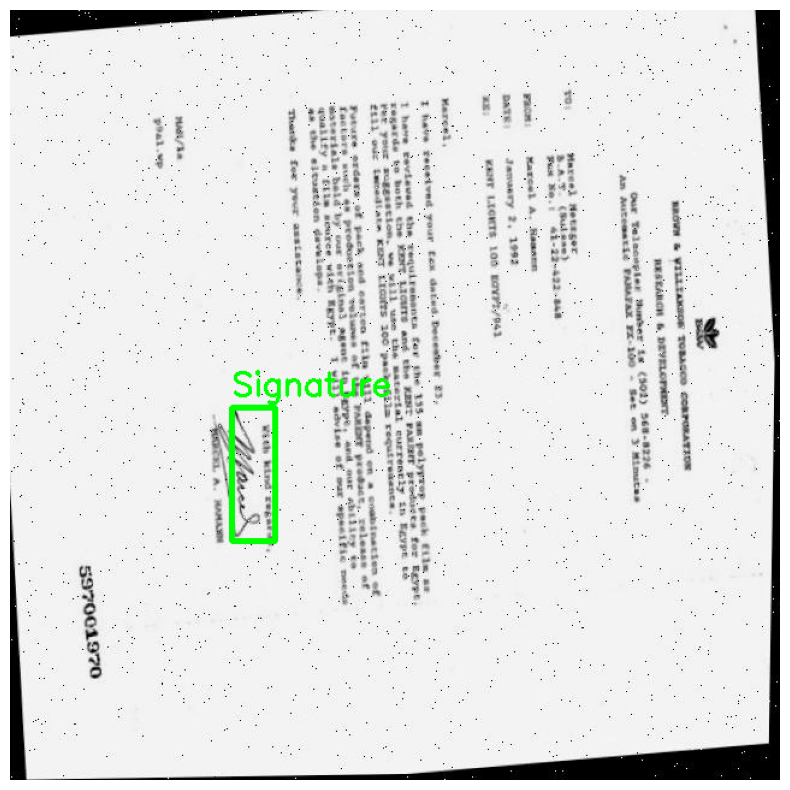

In [8]:
#output_text="<|box_start|>(520,264),(683,328)<|box_end|> signature"
visualize_prediction(TEST_IMAGE_PATH, output_text)
